In [1]:
import pandas as pd
from sklearn.model_selection import KFold, cross_val_score
import numpy as np
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv("Data/patient_features_early_stage.csv",sep=",")
Y = df['relapse?'].values
df.drop(['id','relapse?'], inplace=True, axis=1)
print ("Total number of relapsed patient in the data:",np.count_nonzero(Y))
print ("Total number of survived patient in the data:",len(Y)-np.count_nonzero(Y))
print ("Total number of patient:",len(Y))


Total number of relapsed patient in the data: 491
Total number of survived patient in the data: 857
Total number of patient: 1348


# This is the genomic data which contains aneuploidy score from TCGA

In [3]:
###In this data we have Aneuploidy score and status_1p###
df_tcga_luad_dirk_data_clinical_patient = pd.read_csv("Data/TCGA-LUAD-CLIN-PAN-CAN-2018/data_clinical_patient.txt",sep = "\t",comment='#')
df_tcga_luad_dirk_data_clinical_sample = pd.read_csv("Data/TCGA-LUAD-CLIN-PAN-CAN-2018/data_clinical_sample.txt",sep = "\t",comment='#')
patient_data_tcga = pd.merge(df_tcga_luad_dirk_data_clinical_sample,df_tcga_luad_dirk_data_clinical_patient,on='PATIENT_ID')

In [4]:
patient_data_tcga.shape

(566, 89)

In [5]:
new_df_hosp = df[['diagnosis_stage_t', 'diagnosis_stage_n', 'diagnosis_stage_m','gender','race',
                       'age','tumor_stage']]

In [6]:
new_df_hosp.head()

,diagnosis_stage_t,diagnosis_stage_n,diagnosis_stage_m,gender,race,age,tumor_stage
0,T2a,N1,M0,Male,Caucasian,68.0,IIA
1,T1b,N0,M0,Male,Caucasian,63.0,IA
2,T1b,N0,M0,Female,Caucasian,66.0,IA
3,T3,N0,M0,Male,Caucasian,81.0,IIB
4,T1a,N0,M0,Male,Caucasian,63.0,IA


In [7]:
new_df_tcga = patient_data_tcga[["SEX","RACE","AGE","AJCC_PATHOLOGIC_TUMOR_STAGE",
                                 "PATH_M_STAGE","PATH_N_STAGE","PATH_T_STAGE",'ANEUPLOIDY_SCORE']]
new_df_tcga.shape

(566, 8)

We do not need the rows where the Aneuploidy score is not labeled or in other words removing rows which has Aneuploidy  score as nan

In [8]:
new_df_tcga = new_df_tcga[new_df_tcga['ANEUPLOIDY_SCORE'].notna()]
new_df_tcga.shape

(501, 8)

In [9]:
#new_df_tcga.isnull().sum().sum()

cat_cols = []
non_cat_cols = []
for col in list(new_df_tcga.columns):
    if new_df_tcga[col].dtype == object:
        cat_cols.append(col)
    else:
        non_cat_cols.append(col)
        
# fill empty cells of categorical data
new_df_tcga[cat_cols]=new_df_tcga[cat_cols].fillna("na")
new_df_tcga[non_cat_cols]=new_df_tcga[non_cat_cols].fillna(-1)
new_df_tcga.head()


,SEX,RACE,AGE,AJCC_PATHOLOGIC_TUMOR_STAGE,PATH_M_STAGE,PATH_N_STAGE,PATH_T_STAGE,ANEUPLOIDY_SCORE
0,Male,na,70.0,STAGE IV,M1,N2,T2,17.0
1,Male,na,67.0,STAGE IB,M0,N0,T2,24.0
2,Female,na,79.0,STAGE IIIA,M0,N1,T3,17.0
3,Male,na,68.0,STAGE IB,M0,N0,T2,22.0
4,Male,na,66.0,STAGE IIIA,M0,N2,T2,1.0


In [10]:
new_df_tcga.isnull().sum().sum()
new_df_tcga["RACE"].unique()

array(['na', 'White', 'Black or African American', 'Asian',
       'American Indian or Alaska Native'], dtype=object)

In [11]:
###Finding the rows which has all the column having null values##
idx = new_df_tcga.isnull().all(1)
nan_tcga = new_df_tcga.loc[idx]
print (nan_tcga.shape)
print (new_df_tcga.shape)
print ("remaining data after clearing all the nan values:",new_df_tcga.shape[0]-nan_tcga.shape[0])

(0, 8)
(501, 8)
remaining data after clearing all the nan values: 501


In [12]:
new_df_tcga_after_nan = new_df_tcga.drop(list(nan_tcga.index),axis=0)
new_df_tcga_after_nan.head()

,SEX,RACE,AGE,AJCC_PATHOLOGIC_TUMOR_STAGE,PATH_M_STAGE,PATH_N_STAGE,PATH_T_STAGE,ANEUPLOIDY_SCORE
0,Male,na,70.0,STAGE IV,M1,N2,T2,17.0
1,Male,na,67.0,STAGE IB,M0,N0,T2,24.0
2,Female,na,79.0,STAGE IIIA,M0,N1,T3,17.0
3,Male,na,68.0,STAGE IB,M0,N0,T2,22.0
4,Male,na,66.0,STAGE IIIA,M0,N2,T2,1.0


In [13]:
def normalize_tcga_data_same_as_hosp_data():
    new_df_tcga_after_nan.replace(['STAGE IV', 'STAGE IB', 'STAGE IIIA', 'STAGE IA', 'STAGE IIIB','STAGE IIA'], ['IV','IB',
                                  'IIIA','IA','IIIB','IIA'],inplace=True)
    
    new_df_tcga_after_nan['PATH_M_STAGE'] = new_df_tcga_after_nan.PATH_M_STAGE.replace(['M1', 'M0','MX', 'M1B', 'M1A'],
                                                                                        ['M1','M0','Mx','M1b','M1a'])
    
    new_df_tcga_after_nan['PATH_N_STAGE'] = new_df_tcga_after_nan.PATH_N_STAGE.replace(['N2', 'N0', 'N1', 'N3', 'NX'],
                                                                                        ['N2', 'N0', 'N1', 'N3', 'Nx'])
    
    new_df_tcga_after_nan['PATH_T_STAGE'] = new_df_tcga_after_nan.PATH_T_STAGE.replace(['T2', 'T3', 'T1', 'T4', 'T2B','T1B', 'T2A', 'T1A', 'TX'],
                                                                                        ['T2', 'T3', 'T1', 'T4', 'T2b', 'T1b', 'T2a', 'T1a', 'Tx'])
    
    
    new_df_tcga_after_nan['RACE'] = new_df_tcga_after_nan.RACE.replace(['White', 'American Indian or Alaska Native'],'Caucasian')
    
    new_df_tcga_after_nan['RACE'] = new_df_tcga_after_nan.RACE.replace(['Black or African American'],['African'])
    
    return new_df_tcga_after_nan
        


def rename_the_column_name():
    new_df_tcga_after_nan.rename(columns={'SEX': 'gender', 'RACE': 'race','AGE':'age',
                                                                  'AJCC_PATHOLOGIC_TUMOR_STAGE':'tumor_stage',
                                                                
                                                                  'PATH_M_STAGE':'diagnosis_stage_m',
                                                                  'PATH_N_STAGE':'diagnosis_stage_n',
                                                                  'PATH_T_STAGE':'diagnosis_stage_t'},inplace=True)
    
    
    return new_df_tcga_after_nan
    
    

def reorder_the_column_name():
    new_df_tcga_after_nan = new_df_tcga_after_nan[["diagnosis_stage_t","diagnosis_stage_n",
                                                   "diagnosis_stage_m","gender","race",
                                                   "age","tumor_stage","last_recorded_timestamp_months",
                                                   "number_of_radiotherapies","ANEUPLOIDY_SCORE"]]
    
    return new_df_tcga_after_nan
    
new_df_tcga_after_nan = normalize_tcga_data_same_as_hosp_data()
new_df_tcga_after_nan = rename_the_column_name()
new_df_tcga_after_nan = new_df_tcga_after_nan[["diagnosis_stage_t","diagnosis_stage_n",
                                                   "diagnosis_stage_m","gender","race",
                                                   "age","tumor_stage","ANEUPLOIDY_SCORE"]]

###fill the missing values with -1###
new_df_tcga_after_nan = new_df_tcga_after_nan.fillna(-1)
new_df_tcga_after_nan.head()



,diagnosis_stage_t,diagnosis_stage_n,diagnosis_stage_m,gender,race,age,tumor_stage,ANEUPLOIDY_SCORE
0,T2,N2,M1,Male,na,70.0,IV,17.0
1,T2,N0,M0,Male,na,67.0,IB,24.0
2,T3,N1,M0,Female,na,79.0,IIIA,17.0
3,T2,N0,M0,Male,na,68.0,IB,22.0
4,T2,N2,M0,Male,na,66.0,IIIA,1.0


<AxesSubplot:title={'center':'TCGA Data Tumor stage'}>

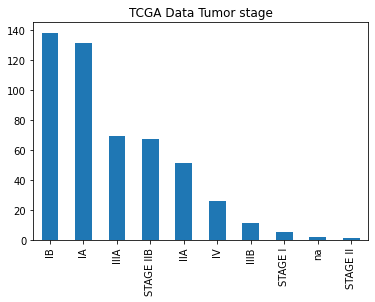

In [14]:
new_df_tcga_after_nan['tumor_stage'].value_counts().plot(kind='bar',title="TCGA Data Tumor stage")

# Normalizing tumor stage in TCGA datasets

In [15]:
for i in new_df_tcga_after_nan.index:
    if(new_df_tcga_after_nan.at[i,'tumor_stage']== "STAGE IIB"):
        new_df_tcga_after_nan.at[i,'tumor_stage']='IIB'
       
    if(new_df_tcga_after_nan.at[i,'tumor_stage']== "STAGE II"):
        new_df_tcga_after_nan.at[i,'tumor_stage']='II'
       
    if(new_df_tcga_after_nan.at[i,'tumor_stage']== "STAGE I"):
        new_df_tcga_after_nan.at[i,'tumor_stage']='I'
       

# Dummy coding TNM stages in SLCG and TCGA datasets
This idea is got from the paper: https://pubmed.ncbi.nlm.nih.gov/31911366/ (Table 3)


In [16]:

def tnm_staging_uniformity():
    for i in new_df_tcga_after_nan.index:     
        if (new_df_tcga_after_nan.at[i, "diagnosis_stage_t"]=="T1" or 
            new_df_tcga_after_nan.at[i, "diagnosis_stage_t"]=="T1a" or 
            new_df_tcga_after_nan.at[i, "diagnosis_stage_t"]=="T1b" or 
            new_df_tcga_after_nan.at[i, "diagnosis_stage_t"]=="T1c" or 
            new_df_tcga_after_nan.at[i, "diagnosis_stage_t"]=="T1mi" or 
            new_df_tcga_after_nan.at[i, "diagnosis_stage_t"]=="Tis"):
            new_df_tcga_after_nan.at[i, "diagnosis_stage_t"] = "T1"

        if (new_df_tcga_after_nan.at[i, "diagnosis_stage_t"]=="T2" or 
            new_df_tcga_after_nan.at[i, "diagnosis_stage_t"]=="T2a" or 
            new_df_tcga_after_nan.at[i, "diagnosis_stage_t"]=="T2b"):
            new_df_tcga_after_nan.at[i, "diagnosis_stage_t"] = "T2"


        if (new_df_tcga_after_nan.at[i, "diagnosis_stage_m"]=="M1" or 
            new_df_tcga_after_nan.at[i, "diagnosis_stage_m"]=="M1a" or 
            new_df_tcga_after_nan.at[i, "diagnosis_stage_m"]=="M1b" or 
            new_df_tcga_after_nan.at[i, "diagnosis_stage_m"]=="M1c"):
            new_df_tcga_after_nan.at[i, "diagnosis_stage_m"] = "M1"


    for i in new_df_hosp.index:
        if (new_df_hosp.at[i, "diagnosis_stage_t"]=="T2" or 
            new_df_hosp.at[i, "diagnosis_stage_t"]=="T2a" or 
            new_df_hosp.at[i, "diagnosis_stage_t"]=="T2b"):
            new_df_hosp.at[i, "diagnosis_stage_t"] = "T2"

        if (new_df_hosp.at[i, "diagnosis_stage_t"]=="T1" or 
            new_df_hosp.at[i, "diagnosis_stage_t"]=="T1a" or 
            new_df_hosp.at[i, "diagnosis_stage_t"]=="T1b" or 
            new_df_hosp.at[i, "diagnosis_stage_t"]=="T1c" or 
            new_df_hosp.at[i, "diagnosis_stage_t"]=="T1mi" or 
            new_df_hosp.at[i, "diagnosis_stage_t"]=="Tis"):
            new_df_hosp.at[i, "diagnosis_stage_t"] = "T1"

        if (new_df_hosp.at[i, "diagnosis_stage_m"]=="M1" or
            new_df_hosp.at[i, "diagnosis_stage_m"]=="M1a" or 
            new_df_hosp.at[i, "diagnosis_stage_m"]=="M1b" or 
            new_df_hosp.at[i, "diagnosis_stage_m"]=="M1c"):
            new_df_hosp.at[i, "diagnosis_stage_m"] = "M1"


def tumor_stage_uniformity():
    for i in new_df_tcga_after_nan.index:     
        if (new_df_tcga_after_nan.at[i, "tumor_stage"]=="0"):
            new_df_tcga_after_nan.at[i, "tumor_stage"] = "overall_stage_tumor_0"

        if (new_df_tcga_after_nan.at[i, "tumor_stage"]=="IA" or 
            new_df_tcga_after_nan.at[i, "tumor_stage"]=="I" or
            new_df_tcga_after_nan.at[i,"tumor_stage"]=="IA1" or 
            new_df_tcga_after_nan.at[i, "tumor_stage"]=="IA2" or 
            new_df_tcga_after_nan.at[i, "tumor_stage"]=="IA3" or 
            new_df_tcga_after_nan.at[i, "tumor_stage"]=="IB" ):
            new_df_tcga_after_nan.at[i, "tumor_stage"] = "overall_stage_tumor_1"


        if (new_df_tcga_after_nan.at[i, "tumor_stage"]=="IIA" or 
            new_df_tcga_after_nan.at[i, "tumor_stage"]=="II" or
            new_df_tcga_after_nan.at[i,"tumor_stage"]=="IIB"):
            new_df_tcga_after_nan.at[i, "tumor_stage"] = "overall_stage_tumor_2"

        if (new_df_tcga_after_nan.at[i, "tumor_stage"]=="III" or 
            new_df_tcga_after_nan.at[i,"tumor_stage"]=="IIIA" or 
            new_df_tcga_after_nan.at[i,"tumor_stage"]=="IIIB" or 
            new_df_tcga_after_nan.at[i,"tumor_stage"]=="IIIC"):   
            new_df_tcga_after_nan.at[i, "tumor_stage"] = "overall_stage_tumor_3"

        if (new_df_tcga_after_nan.at[i, "tumor_stage"]=="IV" or 
            new_df_tcga_after_nan.at[i,"tumor_stage"]=="IVA" or 
            new_df_tcga_after_nan.at[i,"tumor_stage"]=="IVB"):
            new_df_tcga_after_nan.at[i, "tumor_stage"] = "overall_stage_tumor_4"

    for i in new_df_hosp.index:
        if (new_df_hosp.at[i, "tumor_stage"]=="0"):
            new_df_hosp.at[i, "tumor_stage"] = "overall_stage_tumor_0"

        if (new_df_hosp.at[i, "tumor_stage"]=="IA" or 
            new_df_hosp.at[i, "tumor_stage"]=="I" or
            new_df_hosp.at[i,"tumor_stage"]=="IA1" or 
            new_df_hosp.at[i, "tumor_stage"]=="IA2" or 
            new_df_hosp.at[i, "tumor_stage"]=="IA3" or
            new_df_hosp.at[i, "tumor_stage"]=="IB"):
            new_df_hosp.at[i, "tumor_stage"] = "overall_stage_tumor_1"


        if (new_df_hosp.at[i, "tumor_stage"]=="IIA" or 
            new_df_hosp.at[i,"tumor_stage"]=="II" or
            new_df_hosp.at[i,"tumor_stage"]=="IIB"):
            new_df_hosp.at[i, "tumor_stage"] = "overall_stage_tumor_2"

        if (new_df_hosp.at[i, "tumor_stage"]=="III" or 
            new_df_hosp.at[i,"tumor_stage"]=="IIIA" or 
            new_df_hosp.at[i,"tumor_stage"]=="IIIB" or 
            new_df_hosp.at[i,"tumor_stage"]=="IIIC"): 
            new_df_hosp.at[i, "tumor_stage"] = "overall_stage_tumor_3"

        if (new_df_hosp.at[i, "tumor_stage"]=="IV" or 
            new_df_hosp.at[i,"tumor_stage"]=="IVA" or
            new_df_hosp.at[i,"tumor_stage"]=="IVB"):
            new_df_hosp.at[i, "tumor_stage"] = "overall_stage_tumor_4"


tnm_staging_uniformity()
tumor_stage_uniformity()   


# Training a machine learning Regression Model to impute the Aneuploidy score for the hospital patient



In [17]:
train_aneuploidy_score = new_df_tcga_after_nan["ANEUPLOIDY_SCORE"].values
train_data_tcga = new_df_tcga_after_nan.drop(['ANEUPLOIDY_SCORE'], axis = 1)

In [18]:
train_data_tcga.head()

,diagnosis_stage_t,diagnosis_stage_n,diagnosis_stage_m,gender,race,age,tumor_stage
0,T2,N2,M1,Male,na,70.0,overall_stage_tumor_4
1,T2,N0,M0,Male,na,67.0,overall_stage_tumor_1
2,T3,N1,M0,Female,na,79.0,overall_stage_tumor_3
3,T2,N0,M0,Male,na,68.0,overall_stage_tumor_1
4,T2,N2,M0,Male,na,66.0,overall_stage_tumor_3


In [19]:
train_data_tcga.isnull().sum().sum()

0

In [20]:
new_df_hosp.head()

,diagnosis_stage_t,diagnosis_stage_n,diagnosis_stage_m,gender,race,age,tumor_stage
0,T2,N1,M0,Male,Caucasian,68.0,overall_stage_tumor_2
1,T1,N0,M0,Male,Caucasian,63.0,overall_stage_tumor_1
2,T1,N0,M0,Female,Caucasian,66.0,overall_stage_tumor_1
3,T3,N0,M0,Male,Caucasian,81.0,overall_stage_tumor_2
4,T1,N0,M0,Male,Caucasian,63.0,overall_stage_tumor_1


In [21]:
new_df_hosp[["age"]] = new_df_hosp.loc[:,['age']].fillna(value=0)


/home/mohan/anaconda3/envs/py37/lib/python3.7/site-packages/pandas/core/frame.py:3641: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


In [22]:
new_df_hosp.isnull().sum().sum()
nan_values = new_df_hosp.isna()
nan_columns = nan_values.any()
columns_with_nan = new_df_hosp.columns[nan_columns].tolist()

In [23]:
###tcga and hospital data row binding####
new_data_all = pd.concat([train_data_tcga, new_df_hosp])
new_data_all.head()

,diagnosis_stage_t,diagnosis_stage_n,diagnosis_stage_m,gender,race,age,tumor_stage
0,T2,N2,M1,Male,na,70.0,overall_stage_tumor_4
1,T2,N0,M0,Male,na,67.0,overall_stage_tumor_1
2,T3,N1,M0,Female,na,79.0,overall_stage_tumor_3
3,T2,N0,M0,Male,na,68.0,overall_stage_tumor_1
4,T2,N2,M0,Male,na,66.0,overall_stage_tumor_3


In [24]:
from sklearn import preprocessing
new_data_all_norm = new_data_all.copy()
#scaler = preprocessing.MinMaxScaler()
scaler = preprocessing.StandardScaler()
#new_data_all_norm[['age','last_recorded_timestamp_months','number_of_radiotherapies']] = scaler.fit_transform(new_data_all_norm[['age','last_recorded_timestamp_months','number_of_radiotherapies']])
##one hot encoding for categorical variable###
new_data_all_norm = pd.get_dummies(new_data_all_norm, columns=["diagnosis_stage_t","diagnosis_stage_n","diagnosis_stage_m","gender","race","tumor_stage"])
new_data_all_norm.head()

,age,diagnosis_stage_t_T1,diagnosis_stage_t_T2,diagnosis_stage_t_T3,diagnosis_stage_t_T4,diagnosis_stage_t_Tx,diagnosis_stage_n_N0,diagnosis_stage_n_N1,diagnosis_stage_n_N2,diagnosis_stage_n_N3,...,race_Asian,race_Caucasian,race_Latin,race_Others,race_na,tumor_stage_na,tumor_stage_overall_stage_tumor_1,tumor_stage_overall_stage_tumor_2,tumor_stage_overall_stage_tumor_3,tumor_stage_overall_stage_tumor_4
0,70.0,0,1,0,0,0,0,0,1,0,...,0,0,0,0,1,0,0,0,0,1
1,67.0,0,1,0,0,0,1,0,0,0,...,0,0,0,0,1,0,1,0,0,0
2,79.0,0,0,1,0,0,0,1,0,0,...,0,0,0,0,1,0,0,0,1,0
3,68.0,0,1,0,0,0,1,0,0,0,...,0,0,0,0,1,0,1,0,0,0
4,66.0,0,1,0,0,0,0,0,1,0,...,0,0,0,0,1,0,0,0,1,0


In [25]:
train_idx = range(train_data_tcga.shape[0])
test_idx = range(train_data_tcga.shape[0],new_data_all_norm.shape[0])

print(train_idx)
print(test_idx)

range(0, 501)
range(501, 1849)


Text(0.5, 1.0, 'Distribution of Aneuploidy Scores in Training Data')

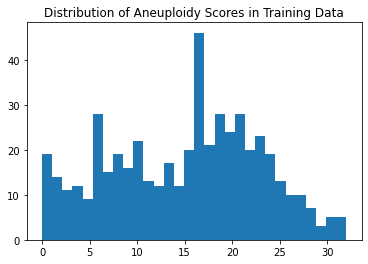

In [26]:
np.histogram(train_aneuploidy_score)
_ = plt.hist(train_aneuploidy_score, bins=30) 
plt.title("Distribution of Aneuploidy Scores in Training Data")

In [27]:
new_data_all_norm.head()

,age,diagnosis_stage_t_T1,diagnosis_stage_t_T2,diagnosis_stage_t_T3,diagnosis_stage_t_T4,diagnosis_stage_t_Tx,diagnosis_stage_n_N0,diagnosis_stage_n_N1,diagnosis_stage_n_N2,diagnosis_stage_n_N3,...,race_Asian,race_Caucasian,race_Latin,race_Others,race_na,tumor_stage_na,tumor_stage_overall_stage_tumor_1,tumor_stage_overall_stage_tumor_2,tumor_stage_overall_stage_tumor_3,tumor_stage_overall_stage_tumor_4
0,70.0,0,1,0,0,0,0,0,1,0,...,0,0,0,0,1,0,0,0,0,1
1,67.0,0,1,0,0,0,1,0,0,0,...,0,0,0,0,1,0,1,0,0,0
2,79.0,0,0,1,0,0,0,1,0,0,...,0,0,0,0,1,0,0,0,1,0
3,68.0,0,1,0,0,0,1,0,0,0,...,0,0,0,0,1,0,1,0,0,0
4,66.0,0,1,0,0,0,0,0,1,0,...,0,0,0,0,1,0,0,0,1,0


In [28]:
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.dummy import DummyRegressor
from sklearn.metrics.pairwise import rbf_kernel
import numpy as np
from scipy import sparse
from sklearn.metrics import mean_squared_error
from mvlearn.semi_supervised import CTRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import BayesianRidge
from scipy import linalg


new_data_for_relapse_classification = new_data_all_norm.iloc[test_idx]
new_data_all_norm = new_data_all_norm.to_numpy()

def baseline_regression(train_dat,train_response,test_dat):
    dummy_regr = DummyRegressor(strategy="mean")
    dummy_regr.fit(train_dat,train_response)
    pred_result = dummy_regr.predict(test_dat)
    
    return pred_result


def knn_regression(train_dat,train_response,test_dat):
    knn_reg = KNeighborsRegressor()
    param_grid = {'n_neighbors': np.arange(3, 21)}
    score = 'neg_mean_squared_error'
    knn_gscv = GridSearchCV(knn_reg, param_grid, cv=3, scoring = score,n_jobs=-1)
    knn_gscv.fit(train_dat,train_response)
    knn =  KNeighborsRegressor(knn_gscv.best_params_['n_neighbors'])
    print ("Best Neighbors:",knn_gscv.best_params_['n_neighbors'])
    knn.fit(train_dat,train_response)
    pred_result =knn.predict(test_dat)
    return pred_result


def neural_nets_regression(train_dat,train_response,test_dat):
    neur_regr = MLPRegressor(random_state=1)
    
    tuned_parameters = [{'hidden_layer_sizes': [1,2,3,4,5,6,7,8],
                        'activation': ['relu'],
                        'solver':['lbfgs'], 'alpha':[0.0001],
                        'batch_size':['auto'], 'learning_rate':['constant'],
                        'learning_rate_init':[0.001], 'max_iter':[200]}]
    rgr = GridSearchCV(MLPRegressor(), tuned_parameters,n_jobs=-1, cv=3)
    rgr.fit(train_dat, train_response)
    
    pred_result = rgr.predict(test_dat)
    return pred_result



def gbm_regression(train_dat,train_response,test_dat):
    
    param_grid = {'n_estimators':[10,50,100,500], 
                  'learning_rate': [0.0001, 0.001, 0.01, 0.1, 1.0],
                  'subsample':[0.5, 0.7, 1.0],
                  'max_depth': [3, 7, 9],
                  "max_features":["log2","sqrt"]
                 }
    
    score = 'neg_mean_squared_error'
    mdl = GradientBoostingRegressor(random_state=1)
    mdl_gscv = GridSearchCV(mdl, param_grid, cv=3,scoring = score,n_jobs=-1)
    mdl_gscv.fit(train_dat, train_response)
    model =  GradientBoostingRegressor(
                                max_depth= mdl_gscv.best_params_['max_depth'],
                                n_estimators= mdl_gscv.best_params_['n_estimators'],
                                max_features= mdl_gscv.best_params_['max_features'],
                                subsample = mdl_gscv.best_params_['subsample'],
                                learning_rate = mdl_gscv.best_params_['learning_rate'],
                                random_state=1)
    model.fit(train_dat,train_response)
    pred_result = model.predict(test_dat)
    return pred_result


def bayesian_regression(train_dat,train_response,test_dat):
    model = BayesianRidge()
    model.fit(train_dat,train_response)
    pred_result = model.predict(test_dat)
    return pred_result


def svr_regression(train_dat,train_response,test_dat):
    param_grid = {'C': [0.01,0.1,1]}

    score = 'neg_mean_squared_error'
    grid = GridSearchCV(SVR(), param_grid, refit = True, scoring = score,n_jobs=-1,cv = 3) 
   
    
    grid.fit(train_dat,train_response)
    #     model_svr = SVR(model_svr_gs.best_params_['C'])
    #     model_svr.fit(X_scaled,train_response)
    pred_result = grid.predict(test_dat)
    
    return pred_result

def random_forest_regression(train_dat,train_response,test_dat):
    
    RF2 = RandomForestRegressor(random_state=1)
    score = 'neg_mean_squared_error'
    
    param_grid={
                       'max_depth': range(3,20),
                       'max_features': ["auto", "sqrt", "log2"],
                       'n_estimators': (10, 50, 100, 200,300,400),
                       'bootstrap': [True, False]
                       
                }
   

    RF_gscv = GridSearchCV(RF2, param_grid, cv=3, scoring = score,n_jobs=-1)
    RF_gscv.fit(train_dat, train_response)
    RF =  RandomForestRegressor(max_depth= RF_gscv.best_params_['max_depth'],
                                n_estimators= RF_gscv.best_params_['n_estimators'],
                                max_features= RF_gscv.best_params_['max_features'],
                                bootstrap= RF_gscv.best_params_['bootstrap'],
                                random_state=1)
   
    RF.fit(train_dat, train_response)
    pred_result = RF.predict(test_dat)
    
    return pred_result


def linear_regression(train_dat,train_response,test_dat):
    
    model = LinearRegression()
    model.fit(train_dat,train_response)
    pred_result = model.predict(test_dat)
    
    return pred_result


aneuploidy_predicted_hospital= knn_regression(new_data_all_norm[train_idx],train_aneuploidy_score,new_data_all_norm[test_idx])
# aneuploidy_predicted_hospital= neural_nets_regression(new_data_all_norm[train_idx],train_aneuploidy_score,new_data_all_norm[test_idx])
# aneuploidy_predicted_hospital= random_forest_regression(new_data_all_norm[train_idx],train_aneuploidy_score,new_data_all_norm[test_idx])
#aneuploidy_predicted_hospital= svr_regression(new_data_all_norm[train_idx],train_aneuploidy_score,new_data_all_norm[test_idx])
# aneuploidy_predicted_hospital= gbm_regression(new_data_all_norm[train_idx],train_aneuploidy_score,new_data_all_norm[test_idx])
# aneuploidy_predicted_hospital= baseline_regression(new_data_all_norm[train_idx],train_aneuploidy_score,new_data_all_norm[test_idx])
# aneuploidy_predicted_hospital= linear_regression(new_data_all_norm[train_idx],train_aneuploidy_score,new_data_all_norm[test_idx])
# aneuploidy_predicted_hospital = bayesian_regression(new_data_all_norm[train_idx],train_aneuploidy_score,new_data_all_norm[test_idx])


Best Neighbors: 13


In [29]:
np.savetxt('Predicted_Aneuploidy_knn.txt', aneuploidy_predicted_hospital, delimiter=',')

In [30]:
new_data_for_relapse_classification["aneuploidy_predicted"] = aneuploidy_predicted_hospital
new_data_for_relapse_classification.head()

,age,diagnosis_stage_t_T1,diagnosis_stage_t_T2,diagnosis_stage_t_T3,diagnosis_stage_t_T4,diagnosis_stage_t_Tx,diagnosis_stage_n_N0,diagnosis_stage_n_N1,diagnosis_stage_n_N2,diagnosis_stage_n_N3,...,race_Caucasian,race_Latin,race_Others,race_na,tumor_stage_na,tumor_stage_overall_stage_tumor_1,tumor_stage_overall_stage_tumor_2,tumor_stage_overall_stage_tumor_3,tumor_stage_overall_stage_tumor_4,aneuploidy_predicted
0,68.0,0,1,0,0,0,0,1,0,0,...,1,0,0,0,0,0,1,0,0,15.153846
1,63.0,1,0,0,0,0,1,0,0,0,...,1,0,0,0,0,1,0,0,0,14.615385
2,66.0,1,0,0,0,0,1,0,0,0,...,1,0,0,0,0,1,0,0,0,11.230769
3,81.0,0,0,1,0,0,1,0,0,0,...,1,0,0,0,0,0,1,0,0,10.076923
4,63.0,1,0,0,0,0,1,0,0,0,...,1,0,0,0,0,1,0,0,0,14.615385


In [31]:
new_data_for_relapse_classification.shape

(1348, 30)

<AxesSubplot:title={'center':'Predicted Aneuploidy'}, ylabel='Frequency'>

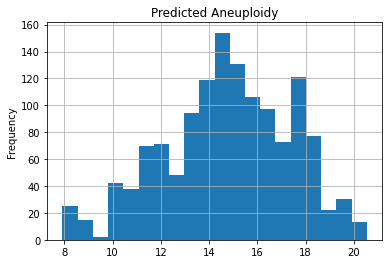

In [32]:
new_data_for_relapse_classification["aneuploidy_predicted"].plot.hist(bins = 20,grid = True,title = "Predicted Aneuploidy")